## Introduction

One of my friends will re-relocate from Austin, TA to New York City. His family want to re-open Supply Store to Japanese restaurants in New York city like what they did in Austin.   He need some help from me to   determine which neighborhood in new York city he should open his new store based on data science. 

## Problem Description

The objective of this Capstone project is to analyze and select the best locations in the city of New York to open a new Supply Store to Japanese restaurants. Using Data Science methodology and instruments such as Data Analysis and Visualization, this project aims to provide solutions to answer the business question: Where in the city of New York, should the investor open a supply store to Japanese restaurants with steady customer and profits?

## Data

To solve the problem, we will need the following data: 
*  New York City data containing the neighborhoods and boroughs.
*  Latitude and longitude coordinates of those neighborhoods. This is required to plot the map and get the venue data.
*  Venue data, particularly data related to restaurants. We are going to use this data to perform further analysis of the neighborhoods.

## Data Source and Methods to extract them

1. New York City data containing the neighborhoods and boroughs will be obtained from the open data source: https://cocl.us/new_york_dataset. 
2. Get the geographical coordinates of the neighborhoods (latitude and longitude) using Python Geocoder package. 
3. find the number of Japanese restaurants and rating of each restaurants in each neighborhoods.
4. identify the location with more Japanese restaurants with better customer ratings. 
5. Foursquare API to get the venue data for the neighborhoods defined at the previous step. 


## Code starts as the following

In [56]:
#import all the library
from bs4 import BeautifulSoup
import xml

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [57]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'P0SUWNCY4HH5TJ5TAEJ4BL3EXCHX5GY5OBXJJSVUNT5L2KO2' # your Foursquare ID
CLIENT_SECRET = '4BYYZNBKJH1QM0VOWASGYZEJSGM3M1NFU00LCY0X4OC4HXW1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: P0SUWNCY4HH5TJ5TAEJ4BL3EXCHX5GY5OBXJJSVUNT5L2KO2
CLIENT_SECRET:4BYYZNBKJH1QM0VOWASGYZEJSGM3M1NFU00LCY0X4OC4HXW1


In [58]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [59]:
# Get the Neighborhood data from new York city 
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [60]:
ny_data.shape

(306, 4)

## Visualize how many Neighborhoods per Borough

## how many Japanese restaurants  in each neighborhood and borough. & then visualize the results.

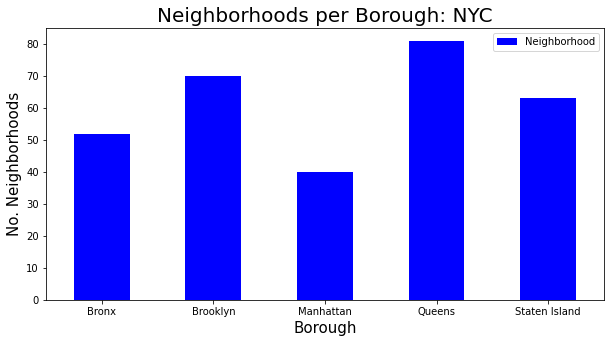

In [61]:
clr = "blue"
#ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [63]:
# queens has most neighborhoods
# prepare neighborhood list that contains japanese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_restaurants=venues[venues['Category']=='Japanese Restaurant']   
#   print('(',count,'/',len(ny_data),')','Japanese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(japanese_restaurants)))
#    print(row)
    for resturant_detail in japanese_restaurants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

In [66]:
type(japanese_rest_ny)
japanese_rest_ny.shape
japanese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Brooklyn,Kensington,4d5c12a01e43236a87eb1583,Sake Sushi
1,Brooklyn,Prospect Heights,5cb5e5f9a35f4600255406c6,Maison Yaki
2,Brooklyn,Williamsburg,51f9b7b3498eefe896caeb23,Shalom Japan
3,Brooklyn,Bedford Stuyvesant,5b3bcb69bfc6d0002ca9bf17,Warude
4,Brooklyn,Brooklyn Heights,479ccb47f964a5206b4d1fe3,Iron Chef House


In [67]:
japanese_rest_ny.shape

(67, 4)

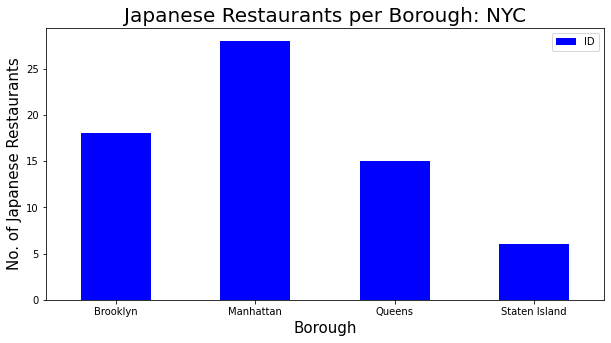

In [68]:
japanese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [69]:
japanese_rest_ny.groupby('Borough')['ID'].count().to_frame().sort_values(by=['ID'], ascending=False). head(10)

,ID
Borough,
Manhattan,28
Brooklyn,18
Queens,15
Staten Island,6


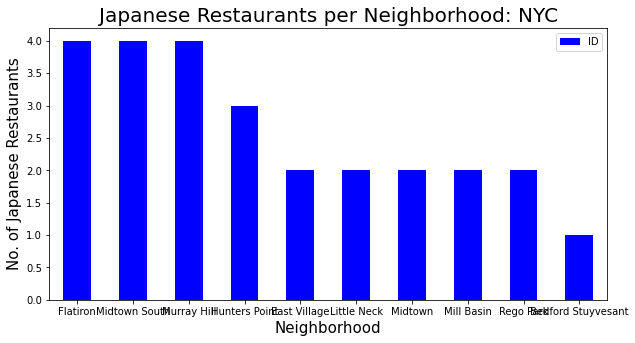

In [70]:
NOofNeigh = 10 # top number for graphing all the same past 10
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
#japanese_rest_ny.groupby('Neighborhood')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [71]:
japanese_rest_ny.groupby('Neighborhood')['ID'].count().to_frame().sort_values(by=['ID'], ascending=False). head(10)

,ID
Neighborhood,
Flatiron,4
Midtown South,4
Murray Hill,4
Hunters Point,3
Rego Park,2
Little Neck,2
Midtown,2
Mill Basin,2
East Village,2


In [72]:
japanese_rest_ny.groupby(['Borough','Neighborhood'])['ID'].count().to_frame().sort_values(by=['ID'], ascending=False). head(10)

ID
Borough   Neighborhood     
Manhattan Flatiron        4
          Midtown South   4
          Murray Hill     3
Queens    Hunters Point   3
          Little Neck     2
          Rego Park       2
Manhattan East Village    2
Brooklyn  Mill Basin      2
Manhattan Midtown         2
Queens    Rockaway Park   1

In [73]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Flatiron']

,Borough,Neighborhood,ID,Name
61,Manhattan,Flatiron,4f7b61f6e4b07aaa5d524842,OOTOYA 大戸屋 (OOTOYA)
62,Manhattan,Flatiron,5bd7a5561c675b0039be9acc,HALL
63,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish
64,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago


In [91]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(japanese_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
japanese_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5fee849cd98e3a6ad14b6179'}, 'response': {'venue': {'id': '4d5c12a01e43236a87eb1583', 'name': 'Sake Sushi', 'contact': {'phone': '7188515299', 'formattedPhone': '(718) 851-5299'}, 'location': {'address': '328 Church Ave', 'crossStreet': 'East 4th Street', 'lat': 40.644138, 'lng': -73.976439, 'labeledLatLngs': [{'label': 'display', 'lat': 40.644138, 'lng': -73.976439}], 'postalCode': '11218', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['328 Church Ave (East 4th Street)', 'Brooklyn, NY 11218', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sake-sushi/4d5c12a01e43236a87eb1583', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 49}, 'url': 'http

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
62,Manhattan,Flatiron,5bd7a5561c675b0039be9acc,HALL,57,9.0,10
63,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish,458,8.9,103
64,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago,158,8.6,26
65,Queens,Sunnyside Gardens,4ba2a9cbf964a520d00d38e3,Oki Japanese Restaurant,11,7.7,5
66,Brooklyn,Fulton Ferry,5cf1562460255e002c5e683c,Bessou,12,8.0,1


In [76]:
japanese_rest_stats_ny.shape

(67, 7)

In [ ]:
japanese_rest_stats_ny.info()

In [77]:
# data processing to type conversion 
japanese_rest_stats_ny['Likes'] = japanese_rest_stats_ny['Likes'].astype('float64')
japanese_rest_stats_ny['Tips'] = japanese_rest_stats_ny['Tips'].astype('float64')
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       67 non-null     object 
 1   Neighborhood  67 non-null     object 
 2   ID            67 non-null     object 
 3   Name          67 non-null     object 
 4   Likes         67 non-null     float64
 5   Rating        67 non-null     float64
 6   Tips          67 non-null     float64
dtypes: float64(3), object(4)
memory usage: 3.8+ KB


In [78]:
japanese_rest_stats_ny.describe()

,Likes,Rating,Tips
count,67.000000,67.000000,67.000000
mean,152.223881,7.728358,44.313433
std,258.459411,1.843811,72.966619
min,0.000000,0.000000,0.000000
25%,13.000000,7.500000,5.000000
50%,40.000000,8.200000,12.000000
75%,169.000000,8.700000,50.500000
max,1222.000000,9.300000,353.000000


In [79]:
# Resturant with maximum Likes
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                    Flatiron
ID              4f7b61f6e4b07aaa5d524842
Name                 OOTOYA 大戸屋 (OOTOYA)
Likes                               1222
Rating                                 9
Tips                                 274
Name: 61, dtype: object

In [80]:
# Resturant with maximum Ratings
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                East Village
ID              510c85e7e4b0056826b88297
Name                                Kura
Likes                                213
Rating                               9.3
Tips                                  63
Name: 26, dtype: object

In [81]:
# Resturant with maximum Tips
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              454f7cc4f964a520dc3c1fe3
Name                            Morimoto
Likes                                792
Rating                               8.9
Tips                                 353
Name: 25, dtype: object

In [82]:
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
11,East Village,9.250
23,Hunters Point,9.000
9,Cobble Hill,9.000
27,Lindenwood,8.900
6,Chelsea,8.900
36,Park Slope,8.900
14,Flatiron,8.875
35,North Side,8.800
10,Downtown,8.800
1,Boerum Hill,8.700


In [83]:
ny_borough_stats=japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.392857
0,Brooklyn,8.100000
2,Queens,6.780000
3,Staten Island,5.883333


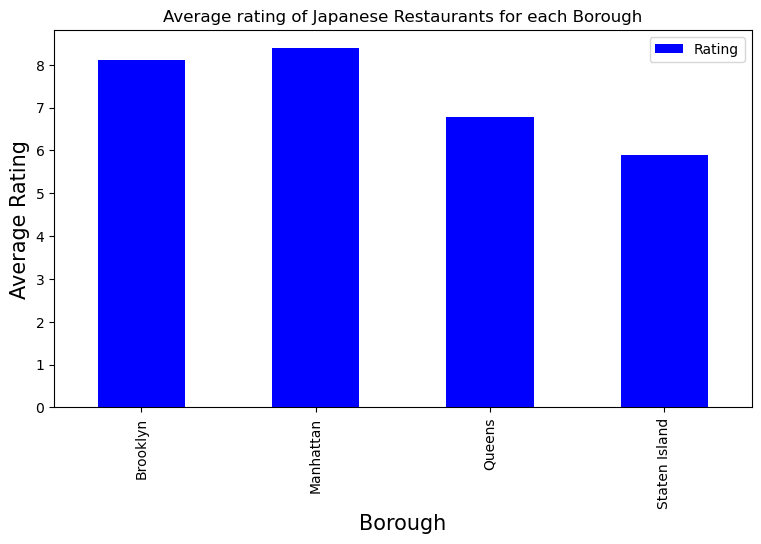

In [84]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Japanese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

In [85]:
japanese_rest_stats_ny.groupby('Borough').mean()['Rating']

Borough
Brooklyn         8.100000
Manhattan        8.392857
Queens           6.780000
Staten Island    5.883333
Name: Rating, dtype: float64

In [86]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Bedford Stuyvesant,8.300
1,Boerum Hill,8.700
2,Brooklyn Heights,8.200
6,Chelsea,8.900
9,Cobble Hill,9.000
10,Downtown,8.800
11,East Village,9.250
14,Flatiron,8.875
15,Fort Greene,8.600
17,Fulton Ferry,8.000


We will join this Dataset to original New York data to get longitude and latitude

In [87]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,8.300
1,Brooklyn,Boerum Hill,40.685683,-73.983748,8.700
2,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.200
3,Manhattan,Chelsea,40.744035,-74.003116,8.900
4,Staten Island,Chelsea,40.594726,-74.189560,8.900
5,Brooklyn,Cobble Hill,40.687920,-73.998561,9.000
6,Brooklyn,Downtown,40.690844,-73.983463,8.800
7,Manhattan,East Village,40.727847,-73.982226,9.250
8,Manhattan,Flatiron,40.739673,-73.990947,8.875
9,Brooklyn,Fort Greene,40.688527,-73.972906,8.600


## show in map

In [88]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Let's add a new field to dataframe for labeling purpose

In [89]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

## Conclusions 

1. Manhattan have the most number of Japanese restaurants.
2. Most of the japanese restaurants in Manhattan are located in Flatiron, Midtown South and Murray Hill 
3. Manhattan has  the best rated Japanese restaurants on average. 

based on all these analysis, the location as showed in the maps are the good candicates to open a supply store for Japanese restaurants